<a href="https://colab.research.google.com/github/Sina-Haz/fastai-kaggle/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

os.environ['KAGGLE_USERNAME'] = 'shazeghi'
os.environ['KAGGLE_KEY'] = '87607fda13bdf94dc22bbf70ef2383fb'

In [2]:
# Firstly lets download dataset:
from pathlib import Path
import os

path = Path('titanic')

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    # if on kaggle we assume we already have data in the directory
    !pip install -Uqq fastai # TODO if on a kaggle notebook (this won't work when we go offline though :/)
elif not os.path.exists(path):
    import zipfile,kaggle
    !kaggle competitions download -c titanic
    zipfile.ZipFile(f'{path}.zip').extractall(path)

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 32.4MB/s]


### Data Cleaning and EDA

In [3]:
# Load data
import pandas as pd
import torch, numpy as np

df = pd.read_csv(path/'train.csv')
eval_df = pd.read_csv(path/'test.csv')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df.isna().sum() # Need to fill in missing values, can do this by filling them in with mode

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [7]:
modes = df.mode(axis=0).iloc[0]

df = df.fillna(modes)
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


array([[<Axes: title={'center': 'Fare'}>]], dtype=object)

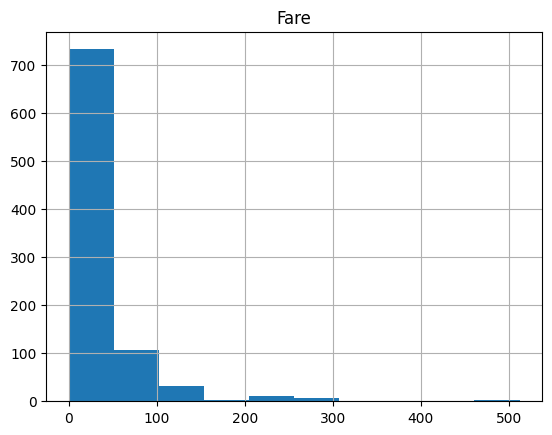

In [8]:
df.hist('Fare') # We see the fare is a long tail distribution, apply log to it to make both linear model and nn better behaved

In [9]:
df['LogFare'] = torch.log(torch.tensor(df['Fare']+1))

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S,2.202765


In [10]:
# for categorical variables, want to make them binary by adding extra columns per category, can do this with pandas
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [11]:
df = pd.get_dummies(df, columns = ['Sex', 'Pclass', 'Embarked'])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [12]:
added_cols = list(df.columns[len(df.columns)-8:])
added_cols

indep_cols = ['Age', 'SibSp', 'LogFare', 'Parch'] + added_cols

dep = df.Survived

In [16]:
print(df[indep_cols].dtypes)
df[indep_cols].astype(float)

Age           float64
SibSp           int64
LogFare       float64
Parch           int64
Sex_female       bool
Sex_male         bool
Pclass_1         bool
Pclass_2         bool
Pclass_3         bool
Embarked_C       bool
Embarked_Q       bool
Embarked_S       bool
dtype: object


,Age,SibSp,LogFare,Parch,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1.0,2.110213,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,38.0,1.0,4.280593,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,26.0,0.0,2.188856,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,35.0,1.0,3.990834,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,35.0,0.0,2.202765,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0.0,2.639057,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
887,19.0,0.0,3.433987,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
888,24.0,1.0,3.196630,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,26.0,0.0,3.433987,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [17]:
# Now convert data to tensors so we can train on it
from torch import tensor

t_dep = tensor(dep)
t_indep = tensor(df[indep_cols].astype(float).values, dtype=torch.float)

### Setting up our Linear Model

In [20]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeff = torch.rand(n_coeff)-0.5 # to get random coefficients b/w (-.5, .5)

In [31]:
# Now all we need to do to feed forward our linear model is multiply each row by coeffs and sum
# Since for all categorical values we have its own column, no need for bias term

(t_indep*coeff) # can do this multiplication easily and element wise using broadcasting
# we can see though that the age column much larger than all the others

tensor([[-10.1838,   0.1386,   0.5084,  ...,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   1.0312,  ...,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.5273,  ...,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.1096,   0.1386,   0.7701,  ...,  -0.0000,   0.0000,   0.3625],
        [-12.0354,   0.0000,   0.8273,  ...,  -0.4392,   0.0000,   0.0000],
        [-14.8128,   0.0000,   0.5225,  ...,  -0.0000,   0.2103,   0.0000]])

In [36]:
max, ind = torch.max(t_indep, axis=0)
t_indep /= max
t_indep

tensor([[0.2750, 0.1250, 0.3381,  ..., 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.6859,  ..., 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.3507,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.3000, 0.1250, 0.5122,  ..., 0.0000, 0.0000, 1.0000],
        [0.3250, 0.0000, 0.5502,  ..., 1.0000, 0.0000, 0.0000],
        [0.4000, 0.0000, 0.3476,  ..., 0.0000, 1.0000, 0.0000]])

In [37]:
raw_preds = (t_indep*coeff).sum(axis=1) # to get our raw predictions

In [38]:
raw_preds[:10]

tensor([ 0.2992, -0.2521,  0.3132,  0.5557,  0.2102,  0.1233,  0.3761,  0.4498,
         0.2439, -0.3199])

In [40]:
# can just use L1 dist as loss for this to keep it simple
loss = torch.abs(raw_preds - t_dep).mean()
loss

tensor(0.5036)

In [44]:
# now lets just make that into a function lol
def get_preds(indep, coeff): return (indep*coeff).sum(axis=1)
def get_loss(indep, coeff, dep): return torch.abs(get_preds(indep, coeff) - dep).mean()